# Notebook for adjusting IRCAD segmentation maps (labels) to CholecSeg8k.

## Cholect8kSeg dataset - classes and corresponding values

In [8]:
# Our official color mappig, matching with Cholect -> class : rgb

# Class 0 Black Background #7F7F7F 127  127 127
# Class 1 Abdominal Wall #D28C8C 210 140 140
# Class 2 Liver #FF7272 255 114 114
# Class 3 Gastrointestinal Tract #E7469C 231 70 156
# Class 4 Fat #BAB74B 186 183 75
# Class 5 Grasper #AAFF00 170 255 0
# Class 6 Connective Tissue #FF5500 255 85 0
# Class 7 Blood #FF0000 255 0 0
# Class 8 Cystic Duct #FFFF00 255 255 0
# Class 9 L-hook Electrocautery #A9FFB8 169 255 184
# Class 10 Gallbladder #FFA0A5255 160 165
# Class 11 Hepatic Vein #003280 0 50 128
# Class 12 Liver Ligament #6F4A00 111 74 0


## IRCAD dataset - classes and corresponding values

In [ ]:
# IRCAD classes and corresponding values
# Liver 26 26 26  
# Abdominal Wall 77 77 77  
# Fat 102, 102, 102  
# Gallblader 51 51 51  
# tool shaft  179  179 179  
# tool tip  153  153 153
# liver ligament 128 128 128

## Assign Cholect8kSeg classes to IRCAD classes. Segmentation maps will be saved as greyscale.

In [2]:
import numpy as np
from tqdm import tqdm 
import os
import torch
import glob
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [1]:

speidel_mapping = {
2: (26, 26, 26),
1: (77,77,77),
4:(102, 102, 102),
10:(51, 51, 51),
5:(179, 179, 179),
12:(128,128,128)
}

speidel_mapping_r = {v: k for k, v in speidel_mapping.items()}
speidel_mapping_r[(153,153,153)] = 5 # tool tip goes as tool


In [3]:
ircad_labels_path = 'path/to/ircad/labels' # original IRCAD segmentation maps are in folder `labels`
dest_path = "path/to/new/segmentation/maps"

images = [v for v in glob.glob(f"{ircad_labels_path}/*.png")]

if not os.path.exists(dest_path):
        os.makedirs(dest_path)

for im in tqdm(images):
    img = cv2.imread(im)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    seg_map_tensor = torch.from_numpy(np.array(img)).float().cuda()

    # Convert the RGB segmentation map to grayscale using the mapping dictionary
    gray_seg_map = torch.zeros(seg_map_tensor.shape[:2]).cuda()
    for color, class_id in speidel_mapping_r.items():
        mask = (seg_map_tensor == torch.tensor(color).cuda().view(1, 1, -1)).all(dim=2)
        gray_seg_map[mask] = class_id

    # save greyscale img
    output_path = os.path.join(dest_path,os.path.basename(im))
    cv2.imwrite(output_path, gray_seg_map.cpu().numpy())


100%|██████████| 20000/20000 [01:21<00:00, 244.19it/s]


### and sanity check

(256, 452)
(3, 256, 452)
(256, 452, 3)


Text(0.5, 1.0, 'restored')

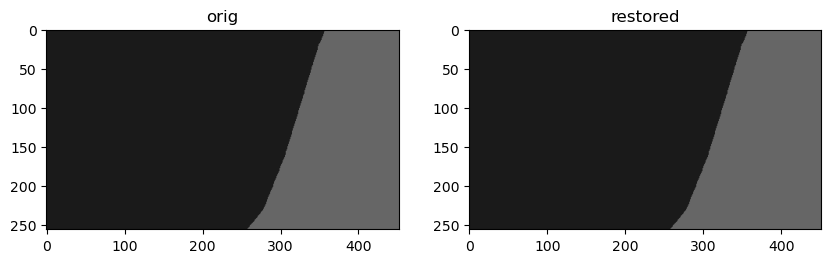

In [4]:
import matplotlib.pyplot as plt

img_p = 'img00087_ircad18.png'

orig_mask = cv2.imread(os.path.join(ircad_labels_path,img_p))
orig_mask = cv2.cvtColor(orig_mask, cv2.COLOR_BGR2RGB)

img = cv2.imread(os.path.join(dest_path,img_p), cv2.IMREAD_GRAYSCALE)
print(img.shape)

speidel_mapping = {
2: (26, 26, 26),
1: (77,77,77),
4:(102, 102, 102),
10:(51, 51, 51),
5:(179, 179, 179),
12:(128,128,128)
}

def map_function(mapping_dict, i): 
    return lambda x: mapping_dict[x][i]


# apply the mapping for each channel using np.vectorize and the mapping dictionaries
mapped_array_channel_1 = np.vectorize(map_function(speidel_mapping, 0))(img[:,:])
mapped_array_channel_2 = np.vectorize(map_function(speidel_mapping, 1))(img[:,:])
mapped_array_channel_3 = np.vectorize(map_function(speidel_mapping, 2))(img[:,:])

# combine the mapped channels back into a single array
mapped_array = np.array([mapped_array_channel_1, mapped_array_channel_2, mapped_array_channel_3])
print(mapped_array.shape)
mapped_array = mapped_array.transpose((1, 2, 0)).astype('uint8')
print(mapped_array.shape)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 10))

# Display the first image in the first subplot
ax1.imshow(orig_mask)
ax1.set_title('orig')

# Display the second image in the second subplot
ax2.imshow(mapped_array)
ax2.set_title('restored')

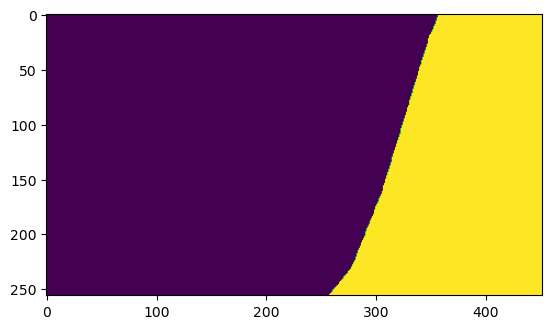

In [21]:
plt.imshow(mapped_array[:,:,0])

In [22]:
np.unique(img)

array([2, 4], dtype=uint8)